In [1]:
# Load libraries
import torch
from torch import nn
from torch import optim
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [2]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

#make sure the model runs and backpropogates deterministically
torch.backends.cudnn.deterministic = True

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## LossPlot comparison

In [13]:
def getLoss(filepath):
  vals = []
  with open(filepath, 'r') as f:
    for line in f:
      vals.append(float(line.split(" ")[1][:-2]))

  return vals

In [16]:
best_adam_d_losses = getLoss('/content/best_d_losses.txt')
best_adam_g_losses = getLoss('/content/best_g_losses.txt')

default_adam_d_losses = getLoss('/content/adam_d_d_losses.txt')
default_adam_g_losses = getLoss('/content/adam_d_g_losses.txt')

default_sgd_d_losses = getLoss('/content/sgd_d_d_losses.txt')
default_sgd_g_losses = getLoss('/content/sgd_d_g_losses.txt')

momentum_sgd_d_losses = getLoss('/content/msgd_d_losses.txt')
momentum_sgd_g_losses = getLoss('/content/msgd_g_losses.txt')

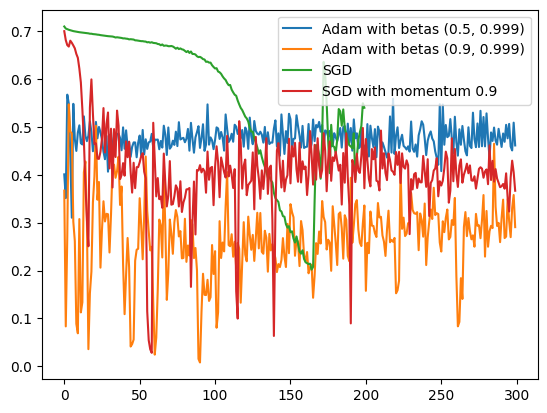

In [19]:
plt.plot(best_adam_d_losses, label = "Adam with betas (0.5, 0.999)")
plt.plot(default_adam_d_losses, label = "Adam with betas (0.9, 0.999)")
plt.plot(default_sgd_d_losses, label = "SGD")
plt.plot(momentum_sgd_d_losses, label = "SGD with momentum 0.9")
plt.legend()
plt.show()

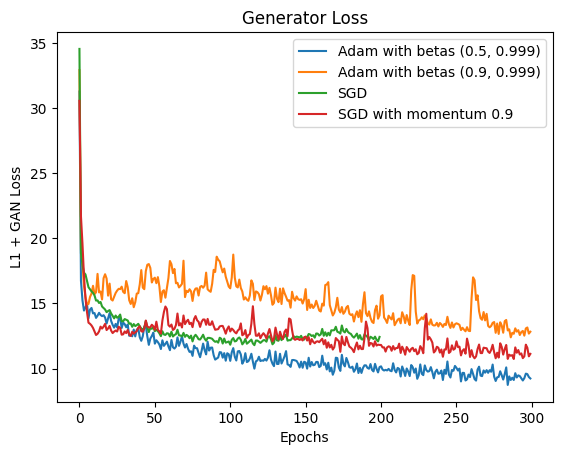

In [23]:
plt.plot(best_adam_g_losses, label = "Adam with betas (0.5, 0.999)")
plt.plot(default_adam_g_losses, label = "Adam with betas (0.9, 0.999)")
plt.plot(default_sgd_g_losses, label = "SGD")
plt.plot(momentum_sgd_g_losses, label = "SGD with momentum 0.9")
plt.xlabel("Epochs")
plt.ylabel("L1 + GAN Loss")
plt.title("Generator Loss")
plt.legend()
plt.show()

## Model Inference

### Generator and Discriminator

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 2):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = stride, bias = False, padding_mode = "reflect"),
            # no need for bias since we are using BatchNorm2D
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        return self.conv(x)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            # 2 * in_channels since it is taking 2 images
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:-1]:
            layers.append(
                CNNBlock(in_channels = in_channels, out_channels = feature, stride = 2)
            )
            in_channels = feature
        
        layers.append(
            CNNBlock(in_channels, features[-1], stride = 1)
        )
        
        layers.append(
            nn.Conv2d(
                features[-1], 1, kernel_size = 4, stride = 1, padding = 1, padding_mode = "reflect"
            )
        )
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, X, Y):
        X = torch.cat([X,Y], dim = 1)
        X = self.initial(X)
        return self.model(X)

In [5]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = True, activation = "relu", use_dropout=False): 
        super().__init__()
        
        # different from UNet since there are no bunch of conv and then down. Rather a single conv and down
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias = False, padding_mode = "reflect")
            if downsample
            else nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if activation == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, X):
        X = self.conv(X)
        if self.use_dropout:
            return self.dropout(X)
        
        return X

In [6]:
class Generator(nn.Module):
    def __init__(self, in_channels: int = 3, features :int  = 64):
        super().__init__()
        
        # no batchNorm in the first layer
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size = 4, stride = 2, padding = 1, bias = True, padding_mode = "reflect"),
#             nn.LeakyReLU(0.2),
        ) # 256 -> 128
        
        self.down1 = Block(features, features*2, downsample = True, activation = "leaky", use_dropout=False) # 128 -> 64
        self.down2 = Block(features*2, features*4, downsample = True, activation = "leaky", use_dropout=False) # 64 -> 32
        self.down3 = Block(features*4, features*8, downsample = True, activation = "leaky", use_dropout=False) # 32 -> 16
        self.down4 = Block(features*8, features*8, downsample = True, activation = "leaky", use_dropout=False) # 16 -> 8
        self.down5 = Block(features*8, features*8, downsample = True, activation = "leaky", use_dropout=False) # 8 -> 4
        self.down6 = Block(features*8, features*8, downsample = True, activation = "leaky", use_dropout=False) # 4 -> 2
        
        # no batchNorm2d for this layer since activations will get zeroed out
        # however, there is no large difference due to this change
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, kernel_size = 4, stride = 2, padding = 1, bias = True, padding_mode = "reflect"),
            nn.ReLU()
        )
        
        # Twice the size since it will receive concatenation of layer below and the layer across 
        self.up1 = Block(features*8, features*8, downsample = False, activation = "relu", use_dropout=True)
        self.up2 = Block(features*8*2, features*8, downsample = False, activation = "relu", use_dropout=True)
        self.up3 = Block(features*8*2, features*8, downsample = False, activation = "relu", use_dropout=True)
        self.up4 = Block(features*8*2, features*8, downsample = False, activation = "relu", use_dropout=False)
        self.up5 = Block(features*8*2, features*4, downsample = False, activation = "relu", use_dropout=False)
        self.up6 = Block(features*4*2, features*2, downsample = False, activation = "relu", use_dropout=False)
        self.up7 = Block(features*2*2, features, downsample = False, activation = "relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            # again, we will get a concatenation of layer below and the layer across
            nn.ConvTranspose2d(features*2, in_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        
        b = self.bottleneck(d7)
        
        u1 = self.up1(b)
        u2 = self.up2(torch.concat([u1, d7], dim = 1))
        u3 = self.up3(torch.concat([u2, d6], dim = 1))
        u4 = self.up4(torch.concat([u3, d5], dim = 1))
        u5 = self.up5(torch.concat([u4, d4], dim = 1))
        u6 = self.up6(torch.concat([u5, d3], dim = 1))
        u7 = self.up7(torch.concat([u6, d2], dim = 1))
        
        pred = self.final_up(torch.concat([u7, d1], dim = 1))
        
        return pred

In [26]:
!tar -xf generator.pth.tar

tar: This does not look like a tar archive
tar: Skipping to next header
tar: Exiting with failure status due to previous errors


In [27]:
!ls -lha

total 6.1M
drwxr-xr-x 1 root root 4.0K May  7 14:20 .
drwxr-xr-x 1 root root 4.0K May  7 13:51 ..
-rw-r--r-- 1 root root 6.8K May  7 14:04 adam_d_d_losses.txt
-rw-r--r-- 1 root root 6.6K May  7 14:04 adam_d_g_losses.txt
-rw-r--r-- 1 root root 6.8K May  7 14:04 best_d_losses.txt
-rw-r--r-- 1 root root 6.5K May  7 14:04 best_g_losses.txt
drwxr-xr-x 4 root root 4.0K May  3 13:30 .config
-rw-r--r-- 1 root root 6.0M May  7 14:21 generator.pth.tar
-rw-r--r-- 1 root root 6.8K May  7 14:11 msgd_d_losses.txt
-rw-r--r-- 1 root root 6.6K May  7 14:11 msgd_g_losses.txt
drwxr-xr-x 1 root root 4.0K May  3 13:31 sample_data
-rw-r--r-- 1 root root 4.5K May  7 14:04 sgd_d_d_losses.txt
-rw-r--r-- 1 root root 4.4K May  7 14:04 sgd_d_g_losses.txt


In [29]:
generator = Generator()

In [ ]:
checkpoint = torch.load(checkpoint_file, map_location=device)
generator.load_state_dict(checkpoint["state_dict"])

In [ ]:
# Load images

In [ ]:
generator.eval()
with torch.no_grad():
    input = X.unsqueeze(dim = 0)
    Y_fake = generator(input)

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(X.reshape(256, 256, 3))
plt.subplot(1,2,2)
plt.imshow(Y_fake.reshape(256, 256, 3))